# Monte Carlo class 
---
**Option pricing subject**

In [49]:
!pip install sobol_seq

In [50]:
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy
from scipy.stats import skewnorm
from scipy.stats import norm
# from scipy.stats import gmean
import sobol_seq
from typing import Iterable, Any
import time
import seaborn as sns
sns.set()

$$    dS_{t} = \alpha \left( b - S_{t} \right)dt + \sigma \sqrt{ S_{t}  } dW_{t}   \; \; \; \text{où} \; \; W_{t} \sim MB   $$

In [2]:
def cir_st_disc(s_0, alpha, b, sigma, k: int= 20, delta: float=1, T= 1, seed= None):
    """  Simulate one path of CIR Model  """
    np.random.seed(seed)
    random.seed(seed)

    # Instance stock price ts and append it first value
    s_t = []
    s_t_neg= []
    s_t.append(s_0)
    s_t_neg.append(s_0)
    
    k= int(T/delta)
    
    for i in range(k):
        s_t_value= np.maximum(s_t[-1], 0) # because a price can't be negative, so we enforce our processus
        # to be positive or 0

        # We generata a normal number
        # cuz' (W_{t+1} - W_{t} follow a N(0, delta)
        epsilon= np.random.normal()

        mu= alpha*(b - s_t_value)*delta
        sigma_s_t= sigma * np.sqrt(s_t_value * delta)

        d_s_t= mu + sigma_s_t*epsilon
        d_s_t_neg= mu - sigma_s_t*epsilon

        s_t.append(s_t_value + d_s_t)
        s_t_neg.append(s_t_value + d_s_t_neg)

    return np.array(s_t), np.array(s_t_neg)

In [3]:
# Params
T= 1
k= 20
s_0= 1
strike= 1
alpha= 0.2
b= 0
sigma= 0.3
r= 0.05
n= 100
num_exec= 1000

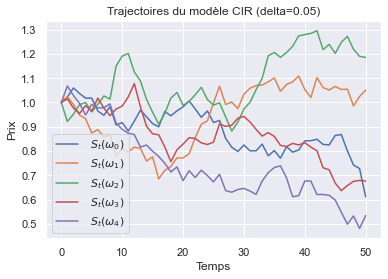

In [4]:
# %matplotlib

num_path= 5
taille= 50

paths= [cir_st_disc(s_0= s_0, alpha= alpha, b= b, sigma= sigma, delta= T/taille)[0]
       for i in range(num_path)]

for i in range(len(paths)) :
    plt.plot(paths[i], label = ' $S_{t}(\omega_{%s})$' % i)

plt.title('Trajectoires du modèle CIR (delta={})'.format(T/k))
plt.xlabel('Temps')
plt.ylabel('Prix')
plt.legend()
plt.show()

$$\widehat{C}_{n}^{ (\text{MC})  } = e^{-rT} \frac{1}{n} \sum_{j=1}^{n} \left[ \left( \frac{1}{k} \sum_{i=1}^{k} S(t_{i}) - K      \right)^{+}   \right]    \underset{n \to +\infty }{ \overset{ \text{p.s}  } { \longrightarrow }  }    C =  e^{-rT}  \mathbb{E} \left[ \left( \frac{1}{k} \sum_{i=1}^{k} S(t_{i}) - K      \right)^{+}   \right]                   $$

In [5]:
def execution_opt_diff(s_t, strike):
    """
    """
    mean_s_t= np.mean(s_t, axis= 0)
    return mean_s_t - strike

def geo_mean_overflow(serie): # against overflow
    """
    """
    a= np.log(serie)
    return np.exp(a.mean())

def execution_geom_diff(s_t, strike):
    """
    """
    mean_s_t= geo_mean_overflow(s_t)
    return mean_s_t - strike

def actualization_execution_opt(exec_value, r, T):
    """
    """
    x= np.maximum(exec_value, 0)
    actualization_factor= np.exp(-r*T)
    return actualization_factor * x

def empirical_quantile(data: Iterable[Any], threshold= 0.05):
    """
    """
    quantile= 1 - threshold/2
    return np.quantile(data, quantile), np.quantile(data, 1 - quantile)

In [6]:
def compare_hist_to_norm(data, bins=25, norm_dist= True, threshold= 0.05):
    fig = plt.figure(figsize=(10, 5))

    mu, std = scipy.stats.norm.fit(data)
    sk = scipy.stats.skew(data)

    scatter, loc, mean= scipy.stats.lognorm.fit(data)

    plt.hist(data, bins=bins, density=True, alpha=0.6, color='purple', label="Data")

    # Plot le PDF.
    xmin, xmax = plt.xlim()
    X = np.linspace(xmin, xmax)

    if norm_dist:
        plt.plot(X, scipy.stats.norm.pdf(X, mu, std), label="Normal Distribution")
        plt.plot(X, scipy.stats.lognorm.pdf(X, scatter, loc, mean), color='black', label="Log-Normal Distribution")

    # Plot empirical quantile
    top_q, low_q = empirical_quantile(data, threshold= threshold)
    ymin, ymax = plt.ylim()
    plt.vlines(top_q, ymin= ymin, ymax= ymax, colors= "red", label= "Empirical Q ({})".format(1-threshold))
    plt.vlines(low_q, ymin= ymin, ymax= ymax, colors= "red")
    plt.text(x= top_q, y= ymax, s= round(top_q, 5))
    plt.text(x=low_q, y=ymax, s=round(low_q, 5))

    title2 = "Moments mu: {}, sig: {}, sk: {}".format(round(mu, 4), round(std, 4), round(sk, 4))
    plt.ylabel("Freq", rotation=90)
    plt.title(title2)
    plt.legend()
    plt.show()
    pass

### 1. Antithetic / Control variable

#### 1.1 Antithetic method

In [7]:
def simulation_callvalue(num_exec, n, s_0, alpha, b, sigma, k, strike, r, T
                         , delta):
    start_time= time.time()
    original_value= []
    antithetic_value= []
    
    for t in range(num_exec): # Simulate num_exec number of CALL value
        stock_s_t= []
        stock_s_t_neg= []
        for i in range(n): # simulate n path to compute the call value (estimate expectation with mean)
            s_t, s_t_neg= cir_st_disc(s_0=s_0, alpha=alpha, b=b, sigma=sigma, k=k
                                    , delta= delta)
            stock_s_t.append(s_t)
            stock_s_t_neg.append(s_t_neg)

        # Cash flow computing
        opt_cachflow= np.array([execution_opt_diff(s_t= s, strike= strike) for s in stock_s_t])
        opt_cachflow_neg= np.array([execution_opt_diff(s_t= s, strike= strike) for s in stock_s_t_neg])

        # Cash flow actualisation
        actu_opt_cachflow= np.array([actualization_execution_opt(c, r= r, T= T) for c in opt_cachflow])
        actu_opt_cachflow_neg= np.array([actualization_execution_opt(c, r= r, T= T) for c in opt_cachflow_neg])

        # Compute CALL value
        original_value.append(np.mean(actu_opt_cachflow, axis= 0))
        antithetic_value.append(np.mean((actu_opt_cachflow + actu_opt_cachflow_neg)/2, axis= 0))

    print("Execution %s seconds" % (time.time()-start_time))
    
    return original_value, antithetic_value

In [116]:
# Simulation phase
original_value, antithetic_value= simulation_callvalue(num_exec, n, s_0, alpha, b, sigma, k, strike
                                                       , r, T, T/k)

Execution 40.70548152923584 seconds


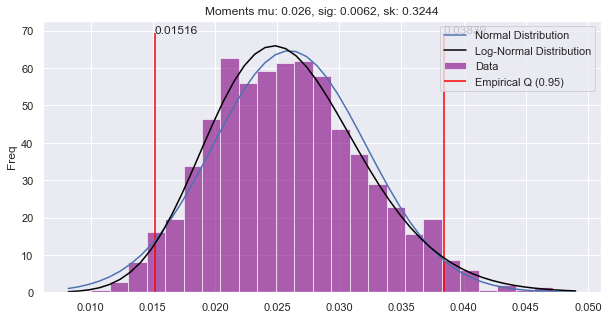

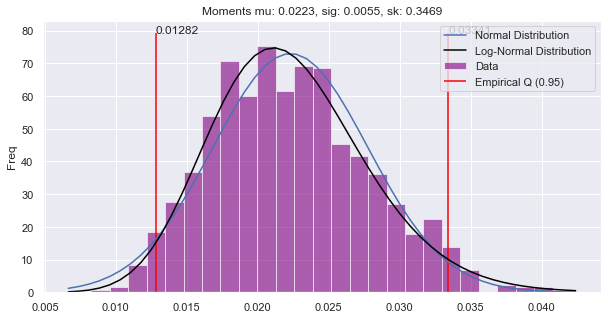

In [117]:
compare_hist_to_norm(original_value)
compare_hist_to_norm(antithetic_value)

#### 1.2 Control variable method

In [10]:
def compute_corr_coef(n, s_0, alpha, b, sigma, k, strike, r, T, delta, num= 100):
    
    start_time= time.time()
    
    stock_s_t= []
    for t in range(num):
        for i in range(n): # simulate n path to compute the call value (estimate expectation with mean)
            s_t, _= cir_st_disc(s_0=s_0, alpha=alpha, b=b, sigma=sigma, k=k
                                    , delta= delta)
            stock_s_t.append(s_t)
            
        opt_cachflow= np.array([execution_opt_diff(s_t= s, strike= strike) for s in stock_s_t])
        opt_cachflow_geom= np.array([execution_geom_diff(s_t= s, strike= strike) for s in stock_s_t])

    # Link between mean and geom
    # No actualisation because it change nothing to do it for both for the cov/var
    opt_cachflow_geom= opt_cachflow_geom - np.mean(opt_cachflow_geom)
    var_cov_mat= np.cov([opt_cachflow_geom, opt_cachflow])
    beta= var_cov_mat[0, 1] / var_cov_mat[0, 0]
    
    print("Execution %s seconds" % (time.time()-start_time))  
    
    return beta


def simulation_control(num_exec, n, s_0, alpha, b, sigma, k, strike, r, T, delta, beta= None):
    
    start_time= time.time()
    
    if beta is None:
        beta= 1 
        
    original_value= []
    control_value= []
    
    for t in range(num_exec): # Simulate num_exec number of CALL value
        stock_s_t= []
        for i in range(n): # simulate n path to compute the call value (estimate expectation with mean)
            s_t, _= cir_st_disc(s_0=s_0, alpha=alpha, b=b, sigma=sigma, k=k
                                    , delta= delta)
            stock_s_t.append(s_t)

        # Cash flow computing
        #On sait que la moyenne arithmétique est un majorant de la moyenne géométrique. 
        #Cela peut donc laisser penser qu'il existe une corrélation non nulle entre les deux.
        opt_cachflow= np.array([execution_opt_diff(s_t= s, strike= strike) for s in stock_s_t])
        opt_cachflow_geom= np.array([execution_geom_diff(s_t= s, strike= strike) for s in stock_s_t])
        
        # Compute mean of both
        mean_cashflow= (1/2)*(opt_cachflow + beta*opt_cachflow_geom)
        
        # Cash flow actualisation
        actu_opt_cachflow= np.array([actualization_execution_opt(c, r= r, T= T) 
                                     for c in opt_cachflow])
        actu_opt_cachflow_control= np.array([actualization_execution_opt(c, r= r, T= T) 
                                     for c in mean_cashflow])
        
        # Compute CALL value
        control_value.append(np.mean(actu_opt_cachflow_control, axis= 0))
        original_value.append(np.mean(actu_opt_cachflow, axis= 0))
        
    print("Execution %s seconds" % (time.time()-start_time))
    
    return original_value, control_value

In [11]:
# # Simulation phase (beta) # useless because beta ~ 1
# beta= compute_corr_coef(n, s_0, alpha, b, sigma, k, strike, r, T, T/k)
# beta
original_value2, control_value= simulation_control(num_exec, n, s_0, alpha, b, sigma, k, strike
                                                       , r, T, T/k)

Execution 43.91395807266235 seconds


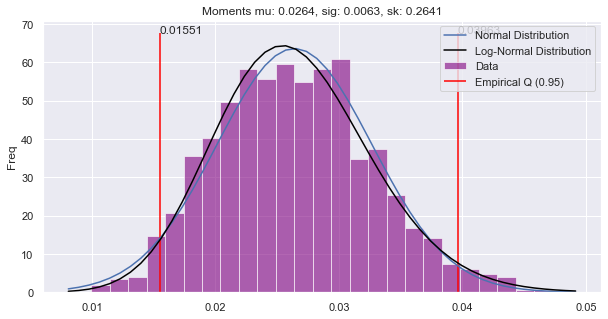

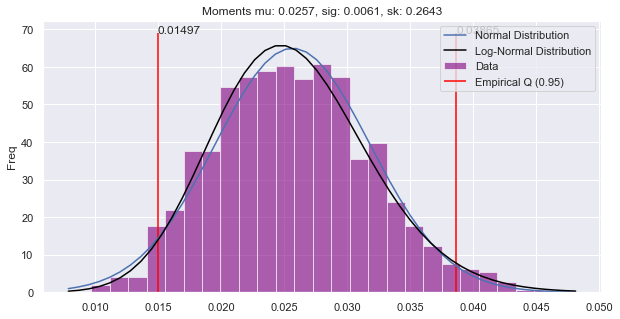

In [12]:
compare_hist_to_norm(original_value2)
compare_hist_to_norm(control_value)

#### 1.3 Test for many parameters

In [13]:
def plot_for_param(series, param, labels, x_name, y_name, title= None):    
    for i in range(len(series)):
        plt.plot(series[i], label = labels[i], marker = '.', markersize = 10)
        
    
    plt.xticks(np.arange(len(param)), [str(p) for p in param])
    plt.title(title)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.legend()
    plt.show()
    pass

In [14]:
def plot_for_param_scatter(series, param, labels, x_name, y_name, title= None, s= 0.1):    
    for i in range(len(series)):
        plt.scatter(y= series[i], x= param
                    , label = labels[i], s= s)
        
    
#     plt.xticks(np.arange(len(param)), [str(p) for p in param])
    plt.title(title)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.legend()
    plt.show()
    pass

In [15]:
def list_of_val_to_list_std(serie):
    return np.std(serie, axis=1)**2

##### Parameter k

In [17]:
# Params
T= 1
k= 20
s_0= 1
strike= 1
alpha= 0.2
b= 0
sigma= 0.3
r= 0.05
n= 100
num_exec= 1000

o_values_anti= []
o_values_cont= []
anti_values= []
cont_values= []

k_list= [5, 10, 20, 50, 100]
for k_i in k_list:
    print(k_i)
    start_time= time.time()
    # Simulation antithetic method
    original_value, antithetic_value= simulation_callvalue(num_exec, n, s_0, alpha, b, sigma, k_i, strike
                                                           , r, T, T/k_i)
    o_values_anti.append(original_value)
    anti_values.append(antithetic_value)
    
    # Simulation control method
    original_value2, control_value= simulation_control(num_exec, n, s_0, alpha, b, sigma, k_i, strike
                                                           , r, T, T/k_i)
    o_values_cont.append(original_value2)
    cont_values.append(control_value)
    
    print("Execution %s seconds" % (time.time()-start_time))

5
Execution 28.265441179275513 seconds
Execution 25.8865065574646 seconds
Execution 54.15194773674011 seconds
10
Execution 29.660807371139526 seconds
Execution 30.21017336845398 seconds
Execution 59.870980739593506 seconds
20
Execution 38.618956089019775 seconds
Execution 37.94095301628113 seconds
Execution 76.5599091053009 seconds
50
Execution 61.19337773323059 seconds
Execution 61.6590781211853 seconds
Execution 122.8524558544159 seconds
100
Execution 101.25716710090637 seconds
Execution 100.68445467948914 seconds
Execution 201.9416217803955 seconds


In [18]:
# Normal MC
std_o_values_anti= list_of_val_to_list_std(o_values_anti)
std_o_values_cont= list_of_val_to_list_std(o_values_cont)
# COntrol and antithetic
std_anti_values= list_of_val_to_list_std(anti_values)
std_cont_values= list_of_val_to_list_std(cont_values)

std_list_anti= [np.log(std_o_values_anti), np.log(std_anti_values)]
std_list_cont= [np.log(std_o_values_cont), np.log(std_cont_values)]

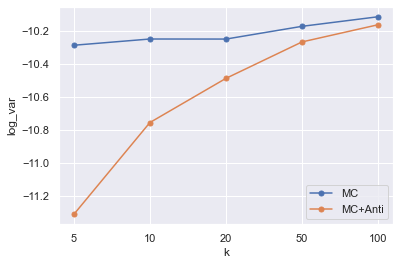

In [19]:
plot_for_param(series= std_list_anti, param= k_list, labels= ["MC", "MC+Anti"]
               , x_name= "k", y_name= "log_var")

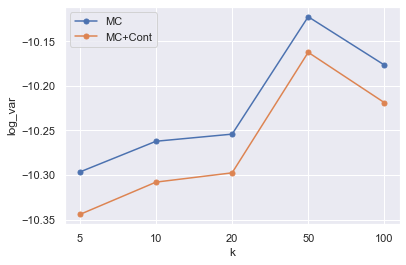

In [20]:
plot_for_param(series= std_list_cont, param= k_list, labels= ["MC", "MC+Cont"]
               , x_name= "k", y_name= "log_var")

##### Parameter sigma

In [145]:
# Params
T= 1
k= 20
s_0= 1
strike= 1
alpha= 0.2
b= 0
sigma= 0.3
r= 0.05
n= 100
num_exec= 1000

o_values_anti= []
o_values_cont= []
anti_values= []
cont_values= []

s_list= [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
for s_i in s_list:
    print(s_i)
    start_time= time.time()
    # Simulation antithetic method
    original_value, antithetic_value= simulation_callvalue(num_exec, n, s_0, alpha, b, s_i, k, strike
                                                           , r, T, T/k)
    o_values_anti.append(original_value)
    anti_values.append(antithetic_value)
    
    # Simulation control method
    original_value2, control_value= simulation_control(num_exec, n, s_0, alpha, b, s_i, k, strike
                                                           , r, T, T/k)
    o_values_cont.append(original_value2)
    cont_values.append(control_value)
    
    print("Execution %s seconds" % (time.time()-start_time))

0.001
Execution 27.379382133483887 seconds
Execution 27.582682847976685 seconds
Execution 54.96206498146057 seconds
0.01
Execution 27.5430645942688 seconds
Execution 27.598920583724976 seconds
Execution 55.14297699928284 seconds
0.1
Execution 27.889307737350464 seconds
Execution 27.7352774143219 seconds
Execution 55.62458515167236 seconds
0.2
Execution 27.61915421485901 seconds
Execution 27.93301796913147 seconds
Execution 55.55217218399048 seconds
0.3
Execution 27.64414691925049 seconds
Execution 27.759817838668823 seconds
Execution 55.40396475791931 seconds
0.4
Execution 27.604815006256104 seconds


<ipython-input-130-cbe213df3032>:10: RuntimeWarning: invalid value encountered in log
  a= np.log(serie)


Execution 27.767903804779053 seconds
Execution 55.372718811035156 seconds
0.5
Execution 27.724450826644897 seconds


<ipython-input-130-cbe213df3032>:10: RuntimeWarning: divide by zero encountered in log
  a= np.log(serie)


Execution 27.60209035873413 seconds
Execution 55.32654118537903 seconds
0.6
Execution 27.342034816741943 seconds
Execution 27.63973641395569 seconds
Execution 54.98177123069763 seconds
0.7
Execution 27.500829696655273 seconds
Execution 27.57889413833618 seconds
Execution 55.079723834991455 seconds
0.8
Execution 27.625368118286133 seconds
Execution 28.0079562664032 seconds
Execution 55.63332438468933 seconds
0.9
Execution 28.102664947509766 seconds
Execution 28.060073614120483 seconds
Execution 56.16273856163025 seconds
0.99
Execution 27.817127227783203 seconds
Execution 27.992149591445923 seconds
Execution 55.809276819229126 seconds


In [146]:
# Normal MC
std_o_values_anti= list_of_val_to_list_std(o_values_anti)
std_o_values_cont= list_of_val_to_list_std(o_values_cont)
# COntrol and antithetic
std_anti_values= list_of_val_to_list_std(anti_values)
std_cont_values= list_of_val_to_list_std(cont_values)

std_list_anti= [np.log(std_o_values_anti), np.log(std_anti_values)]
std_list_cont= [np.log(std_o_values_cont), np.log(std_cont_values)]

<ipython-input-146-c158852aa3a7>:8: RuntimeWarning: divide by zero encountered in log
  std_list_anti= [np.log(std_o_values_anti), np.log(std_anti_values)]
<ipython-input-146-c158852aa3a7>:9: RuntimeWarning: divide by zero encountered in log
  std_list_cont= [np.log(std_o_values_cont), np.log(std_cont_values)]


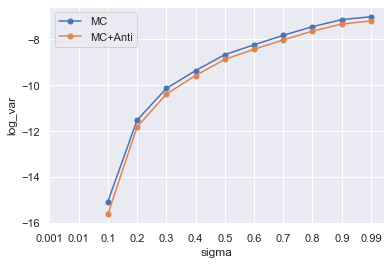

In [147]:
plot_for_param(series= std_list_anti, param= s_list, labels= ["MC", "MC+Anti"]
               , x_name= "sigma", y_name= "log_var")

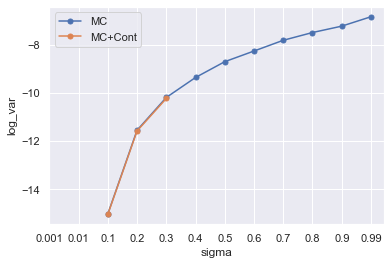

In [148]:
plot_for_param(series= std_list_cont, param= s_list, labels= ["MC", "MC+Cont"]
               , x_name= "sigma", y_name= "log_var")

# plot_for_param_scatter(series= std_list_cont, param= s_list, labels= ["MC", "MC+Cont"]
#                , x_name= "sigma", y_name= "log_std", s= 20)

In [149]:
std_list_cont

[array([        -inf,         -inf, -15.0239859 , -11.55395393,
        -10.19447643,  -9.36650887,  -8.71107711,  -8.26931108,
         -7.82395291,  -7.50240836,  -7.23811158,  -6.84813401]),
 array([        -inf,         -inf, -15.04262186, -11.58321061,
        -10.23716527,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan])]

##### Parameter interest rate

In [150]:
# Params
T= 1
k= 20
s_0= 1
strike= 1
alpha= 0.2
b= 0
sigma= 0.3
r= 0.05
n= 100
num_exec= 1000

o_values_anti= []
o_values_cont= []
anti_values= []
cont_values= []

r_list= [0.001, 0.01, 0.03, 0.05, 0.07, 0.08, 0.09, 0.1]
for r_i in r_list:
    print(r_i)
    start_time= time.time()
    # Simulation antithetic method
    original_value, antithetic_value= simulation_callvalue(num_exec, n, s_0, alpha, b, sigma, k, strike
                                                           , r_i, T, T/k)
    o_values_anti.append(original_value)
    anti_values.append(antithetic_value)
    
    # Simulation control method
    original_value2, control_value= simulation_control(num_exec, n, s_0, alpha, b, sigma, k, strike
                                                           , r_i, T, T/k)
    o_values_cont.append(original_value2)
    cont_values.append(control_value)
    
    print("Execution %s seconds" % (time.time()-start_time))

0.001
Execution 27.509357690811157 seconds
Execution 27.599476099014282 seconds
Execution 55.10883378982544 seconds
0.01
Execution 27.492190837860107 seconds
Execution 27.574522972106934 seconds
Execution 55.06671380996704 seconds
0.03
Execution 27.503405332565308 seconds
Execution 27.6913161277771 seconds
Execution 55.19472146034241 seconds
0.05
Execution 27.598100900650024 seconds
Execution 27.743518114089966 seconds
Execution 55.34161901473999 seconds
0.07
Execution 27.621665716171265 seconds
Execution 29.057482481002808 seconds
Execution 56.67914819717407 seconds
0.08
Execution 29.502763748168945 seconds
Execution 27.841408252716064 seconds
Execution 57.34417200088501 seconds
0.09
Execution 27.882277011871338 seconds
Execution 27.943827152252197 seconds
Execution 55.826104164123535 seconds
0.1
Execution 27.648858785629272 seconds
Execution 27.92013454437256 seconds
Execution 55.56899333000183 seconds


In [151]:
# Normal MC
std_o_values_anti= list_of_val_to_list_std(o_values_anti)
std_o_values_cont= list_of_val_to_list_std(o_values_cont)
# COntrol and antithetic
std_anti_values= list_of_val_to_list_std(anti_values)
std_cont_values= list_of_val_to_list_std(cont_values)

std_list_anti= [np.log(std_o_values_anti), np.log(std_anti_values)]
std_list_cont= [np.log(std_o_values_cont), np.log(std_cont_values)]

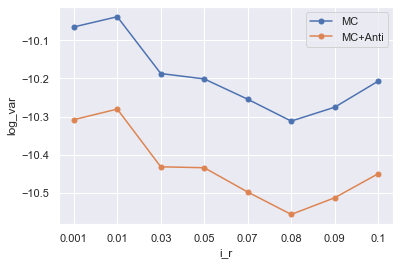

In [152]:
plot_for_param(series= std_list_anti, param= r_list, labels= ["MC", "MC+Anti"]
               , x_name= "i_r", y_name= "log_var")

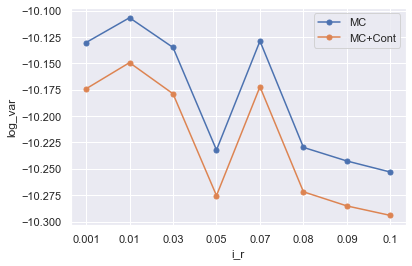

In [153]:
plot_for_param(series= std_list_cont, param= r_list, labels= ["MC", "MC+Cont"]
               , x_name= "i_r", y_name= "log_var")

##### Parameter b (long term mean)

In [154]:
# Params
T= 1
k= 20
s_0= 1
strike= 1
alpha= 0.2
b= 0
sigma= 0.3
r= 0.05
n= 100
num_exec= 1000

o_values_anti= []
o_values_cont= []
anti_values= []
cont_values= []

# b in % of s_0
b_list= [0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
for b_i in b_list:
    print(b_i)
    start_time= time.time()
    # Simulation antithetic method
    original_value, antithetic_value= simulation_callvalue(num_exec, n, s_0, alpha, b_i, sigma, k, strike
                                                           , r, T, T/k)
    o_values_anti.append(original_value)
    anti_values.append(antithetic_value)
    
    # Simulation control method
    original_value2, control_value= simulation_control(num_exec, n, s_0, alpha, b_i, sigma, k, strike
                                                           , r, T, T/k)
    o_values_cont.append(original_value2)
    cont_values.append(control_value)
    
    print("Execution %s seconds" % (time.time()-start_time))

0
Execution 27.539843559265137 seconds
Execution 27.831313133239746 seconds
Execution 55.37115669250488 seconds
0.01
Execution 27.07050061225891 seconds
Execution 27.386150360107422 seconds
Execution 54.457648277282715 seconds
0.1
Execution 27.1365966796875 seconds
Execution 27.423660278320312 seconds
Execution 54.56025695800781 seconds
0.2
Execution 27.178196907043457 seconds
Execution 27.28893733024597 seconds
Execution 54.46713423728943 seconds
0.3
Execution 27.377663135528564 seconds
Execution 27.443854093551636 seconds
Execution 54.8215172290802 seconds
0.4
Execution 27.431453704833984 seconds
Execution 27.708282709121704 seconds
Execution 55.13973641395569 seconds
0.5
Execution 27.528761625289917 seconds
Execution 27.558069467544556 seconds
Execution 55.08683109283447 seconds
0.6
Execution 27.374399423599243 seconds
Execution 27.524424076080322 seconds
Execution 54.898823499679565 seconds
0.7
Execution 27.172817707061768 seconds
Execution 27.36776375770569 seconds
Execution 54.54

In [155]:
# Normal MC
std_o_values_anti= list_of_val_to_list_std(o_values_anti)
std_o_values_cont= list_of_val_to_list_std(o_values_cont)
# COntrol and antithetic
std_anti_values= list_of_val_to_list_std(anti_values)
std_cont_values= list_of_val_to_list_std(cont_values)

std_list_anti= [np.log(std_o_values_anti), np.log(std_anti_values)]
std_list_cont= [np.log(std_o_values_cont), np.log(std_cont_values)]

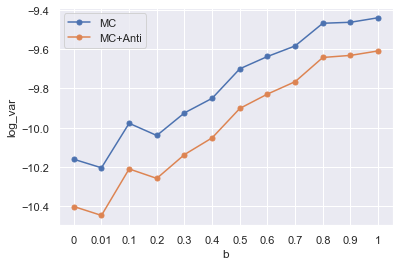

In [156]:
plot_for_param(series= std_list_anti, param= b_list, labels= ["MC", "MC+Anti"]
               , x_name= "b", y_name= "log_var")

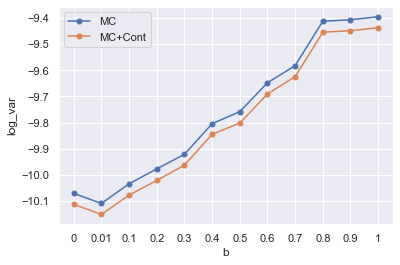

In [157]:
plot_for_param(series= std_list_cont, param= b_list, labels= ["MC", "MC+Cont"]
               , x_name= "b", y_name= "log_var")

##### Parameter number of path simulation 

In [113]:
# Params
T= 1
k= 20
s_0= 1
strike= 1
alpha= 0.2
b= 0
sigma= 0.3
r= 0.05
n= 100
num_exec= 1000

o_values_anti= []
o_values_cont= []
anti_values= []
cont_values= []

# b in % of s_0
n_list= [5, 20, 50, 100, 200, 500, 1000]
for n_i in n_list:
    print(n_i)
    start_time= time.time()
    # Simulation antithetic method
    original_value, antithetic_value= simulation_callvalue(num_exec, n_i, s_0, alpha, b, sigma, k, strike
                                                           , r, T, T/k)
    o_values_anti.append(original_value)
    anti_values.append(antithetic_value)
    
    # Simulation control method
    original_value2, control_value= simulation_control(num_exec, n_i, s_0, alpha, b, sigma, k, strike
                                                           , r, T, T/k)
    o_values_cont.append(original_value2)
    cont_values.append(control_value)
    
    print("Execution %s seconds" % (time.time()-start_time))

5
Execution 2.089228630065918 seconds
Execution 2.1581664085388184 seconds
Execution 4.248392820358276 seconds
20
Execution 8.04868745803833 seconds
Execution 8.152374982833862 seconds
Execution 16.201062440872192 seconds
50
Execution 19.498207330703735 seconds
Execution 19.72510838508606 seconds
Execution 39.223315715789795 seconds
100
Execution 39.10027813911438 seconds
Execution 39.279566049575806 seconds
Execution 78.37984418869019 seconds
200
Execution 80.25467538833618 seconds
Execution 75.79967212677002 seconds
Execution 156.0543475151062 seconds
500
Execution 188.55042576789856 seconds
Execution 187.04998683929443 seconds
Execution 375.600412607193 seconds
1000
Execution 383.4037194252014 seconds
Execution 324.1504442691803 seconds
Execution 707.5541636943817 seconds


In [114]:
# Normal MC
std_o_values_anti= list_of_val_to_list_std(o_values_anti)
std_o_values_cont= list_of_val_to_list_std(o_values_cont)
# COntrol and antithetic
std_anti_values= list_of_val_to_list_std(anti_values)
std_cont_values= list_of_val_to_list_std(cont_values)

std_list_anti= [np.log(std_o_values_anti), np.log(std_anti_values)]
std_list_cont= [np.log(std_o_values_cont), np.log(std_cont_values)]

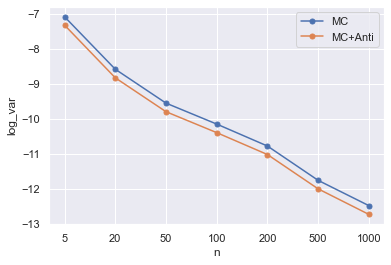

In [115]:
plot_for_param(series= std_list_anti, param= n_list, labels= ["MC", "MC+Anti"]
               , x_name= "n", y_name= "log_var")

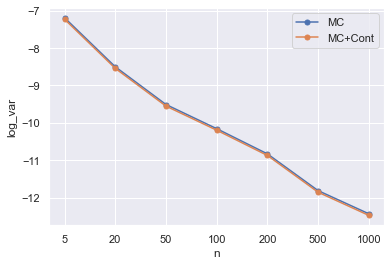

In [116]:
plot_for_param(series= std_list_cont, param= n_list, labels= ["MC", "MC+Cont"]
               , x_name= "n", y_name= "log_var")

In [124]:
# Compute mean call vlaue for all methods
o_mean= np.mean(o_values_anti, axis= 1)
o_mean2= np.mean(o_values_cont, axis= 1)
anti_mean= np.mean(anti_values, axis= 1)
cont_mean= np.mean(cont_values, axis= 1)

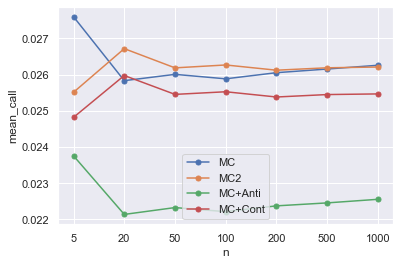

In [158]:
plot_for_param(series= [o_mean, o_mean2, anti_mean, cont_mean], param= n_list
               , labels= ["MC", "MC2", "MC+Anti", "MC+Cont"], x_name= "n", y_name= "mean_call")

##### Parameter number of call value simulation

In [159]:
# Params
T= 1
k= 20
s_0= 1
strike= 1
alpha= 0.2
b= 0
sigma= 0.3
r= 0.05
n= 100
num_exec= 1000

o_values_anti= []
o_values_cont= []
anti_values= []
cont_values= []

num_exec_list= [5, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
for num_i in num_exec_list:
    print(num_i)
    start_time= time.time()
    # Simulation antithetic method
    original_value, antithetic_value= simulation_callvalue(num_i, n, s_0, alpha, b, sigma, k, strike
                                                           , r, T, T/k)
    o_values_anti.append(original_value)
    anti_values.append(antithetic_value)
    
    # Simulation control method
    original_value2, control_value= simulation_control(num_i, n, s_0, alpha, b, sigma, k, strike
                                                           , r, T, T/k)
    o_values_cont.append(original_value2)
    cont_values.append(control_value)
    
    print("Execution %s seconds" % (time.time()-start_time))

5
Execution 0.13866710662841797 seconds
Execution 0.13924765586853027 seconds
Execution 0.278911828994751 seconds
20
Execution 0.5664467811584473 seconds
Execution 0.5734686851501465 seconds
Execution 1.1399154663085938 seconds
50
Execution 1.3908185958862305 seconds
Execution 1.413748025894165 seconds
Execution 2.8055813312530518 seconds
100
Execution 2.7985541820526123 seconds
Execution 2.8075764179229736 seconds
Execution 5.606130599975586 seconds
200
Execution 5.506540775299072 seconds
Execution 5.556220531463623 seconds
Execution 11.062761306762695 seconds
500
Execution 13.698816537857056 seconds
Execution 13.758912324905396 seconds
Execution 27.45772886276245 seconds
1000
Execution 28.48550820350647 seconds
Execution 27.94372534751892 seconds
Execution 56.42923355102539 seconds
2000
Execution 55.2236065864563 seconds
Execution 57.15702414512634 seconds
Execution 112.38063073158264 seconds
5000
Execution 139.24358248710632 seconds
Execution 140.13601970672607 seconds
Execution 279

In [160]:
# Normal MC
std_o_values_anti= [np.std(a)**2 for a in o_values_anti]
std_o_values_cont= [np.std(a)**2 for a in o_values_cont]
# COntrol and antithetic
std_anti_values= [np.std(a)**2 for a in anti_values]
std_cont_values= [np.std(a)**2 for a in cont_values]

std_list_anti= [np.log(std_o_values_anti), np.log(std_anti_values)]
std_list_cont= [np.log(std_o_values_cont), np.log(std_cont_values)]

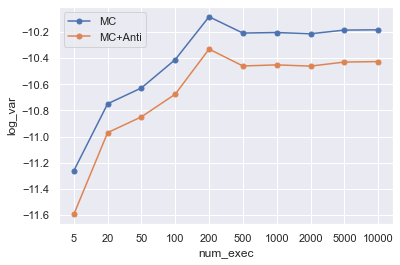

In [161]:
plot_for_param(series= std_list_anti, param= num_exec_list, labels= ["MC", "MC+Anti"]
               , x_name= "num_exec", y_name= "log_var")

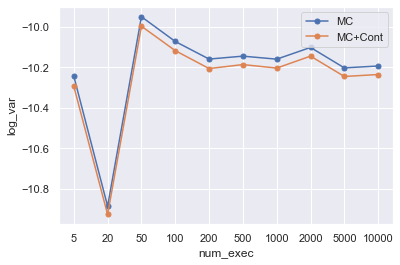

In [162]:
plot_for_param(series= std_list_cont, param= num_exec_list, labels= ["MC", "MC+Cont"]
               , x_name= "num_exec", y_name= "log_var")

##### Parameter alpha

In [163]:
# Params
T= 1
k= 20
s_0= 1
strike= 1
alpha= 0.2
b= 0
sigma= 0.3
r= 0.05
n= 100
num_exec= 1000

o_values_anti= []
o_values_cont= []
anti_values= []
cont_values= []

a_list= [0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
for a_i in a_list:
    print(a_i)
    start_time= time.time()
    # Simulation antithetic method
    original_value, antithetic_value= simulation_callvalue(num_exec, n, s_0, a_i, b, sigma, k, strike
                                                           , r, T, T/k)
    o_values_anti.append(original_value)
    anti_values.append(antithetic_value)
    
    # Simulation control method
    original_value2, control_value= simulation_control(num_exec, n, s_0, a_i, b, sigma, k, strike
                                                           , r, T, T/k)
    o_values_cont.append(original_value2)
    cont_values.append(control_value)
    
    print("Execution %s seconds" % (time.time()-start_time))

0
Execution 28.497471570968628 seconds
Execution 28.172489166259766 seconds
Execution 56.670958280563354 seconds
0.01
Execution 27.44688105583191 seconds
Execution 27.7641122341156 seconds
Execution 55.21099328994751 seconds
0.1
Execution 27.571179389953613 seconds
Execution 28.1729679107666 seconds
Execution 55.745145082473755 seconds
0.2
Execution 27.72498321533203 seconds
Execution 28.098467588424683 seconds
Execution 55.823450803756714 seconds
0.3
Execution 27.781805276870728 seconds
Execution 28.14292073249817 seconds
Execution 55.9247260093689 seconds
0.4
Execution 27.803011655807495 seconds
Execution 28.019763946533203 seconds
Execution 55.8227756023407 seconds
0.5
Execution 27.655433177947998 seconds
Execution 27.99301314353943 seconds
Execution 55.64944386482239 seconds
0.6
Execution 27.8869731426239 seconds
Execution 27.912500381469727 seconds
Execution 55.79947352409363 seconds
0.7
Execution 27.855592250823975 seconds
Execution 27.937639474868774 seconds
Execution 55.7932317

<ipython-input-130-cbe213df3032>:10: RuntimeWarning: invalid value encountered in log
  a= np.log(serie)


Execution 28.01430344581604 seconds
Execution 55.79393935203552 seconds
0.9
Execution 27.845551252365112 seconds


<ipython-input-130-cbe213df3032>:10: RuntimeWarning: divide by zero encountered in log
  a= np.log(serie)


Execution 27.966161251068115 seconds
Execution 55.81171250343323 seconds
1
Execution 27.979873180389404 seconds
Execution 27.84718084335327 seconds
Execution 55.827054023742676 seconds


In [164]:
# Normal MC
std_o_values_anti= list_of_val_to_list_std(o_values_anti)
std_o_values_cont= list_of_val_to_list_std(o_values_cont)
# COntrol and antithetic
std_anti_values= list_of_val_to_list_std(anti_values)
std_cont_values= list_of_val_to_list_std(cont_values)

std_list_anti= [np.log(std_o_values_anti), np.log(std_anti_values)]
std_list_cont= [np.log(std_o_values_cont), np.log(std_cont_values)]

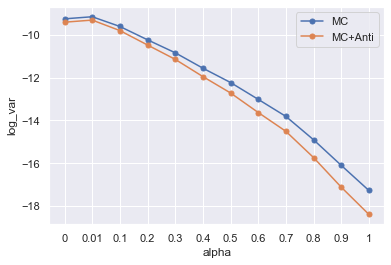

In [165]:
plot_for_param(series= std_list_anti, param= a_list, labels= ["MC", "MC+Anti"]
               , x_name= "alpha", y_name= "log_var")

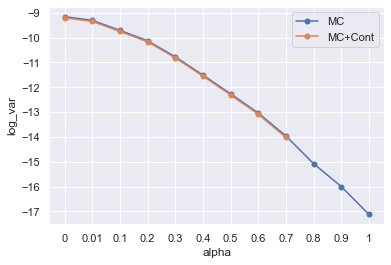

In [166]:
plot_for_param(series= std_list_cont, param= a_list, labels= ["MC", "MC+Cont"]
               , x_name= "alpha", y_name= "log_var")

##### Parameter S_0 and strike in level

In [167]:
# Params
T= 1
k= 20
s_0= 1
strike= 1
alpha= 0.2
b= 0
sigma= 0.3
r= 0.05
n= 100
num_exec= 1000

o_values_anti= []
o_values_cont= []
anti_values= []
cont_values= []

sk_list= [1, 5, 10, 20, 50, 80, 100, 150, 200]
for sk_i in sk_list:
    print(sk_i)
    start_time= time.time()
    # Simulation antithetic method
    original_value, antithetic_value= simulation_callvalue(num_exec, n, sk_i, alpha, b, sigma, k, sk_i
                                                           , r, T, T/k)
    o_values_anti.append(original_value)
    anti_values.append(antithetic_value)
    
    # Simulation control method
    original_value2, control_value= simulation_control(num_exec, n, sk_i, alpha, b, sigma, k, sk_i
                                                           , r, T, T/k)
    o_values_cont.append(original_value2)
    cont_values.append(control_value)
    
    print("Execution %s seconds" % (time.time()-start_time))

1
Execution 27.792351007461548 seconds
Execution 27.99438762664795 seconds
Execution 55.78774666786194 seconds
5
Execution 27.827828884124756 seconds
Execution 28.32977604866028 seconds
Execution 56.157604932785034 seconds
10
Execution 27.885359287261963 seconds
Execution 28.031113862991333 seconds
Execution 55.916473150253296 seconds
20
Execution 27.86847686767578 seconds
Execution 28.000619173049927 seconds
Execution 55.86909604072571 seconds
50
Execution 27.8692364692688 seconds
Execution 28.079365730285645 seconds
Execution 55.94860219955444 seconds
80
Execution 27.94054865837097 seconds
Execution 28.19982123374939 seconds
Execution 56.14136743545532 seconds
100
Execution 27.977500677108765 seconds
Execution 27.945873975753784 seconds
Execution 55.92337465286255 seconds
150
Execution 27.895819425582886 seconds
Execution 28.03007698059082 seconds
Execution 55.925896406173706 seconds
200
Execution 27.76585626602173 seconds
Execution 28.032559633255005 seconds
Execution 55.79941320419

In [168]:
# Normal MC
std_o_values_anti= list_of_val_to_list_std(o_values_anti)
std_o_values_cont= list_of_val_to_list_std(o_values_cont)
# COntrol and antithetic
std_anti_values= list_of_val_to_list_std(anti_values)
std_cont_values= list_of_val_to_list_std(cont_values)

std_list_anti= [np.log(std_o_values_anti), np.log(std_anti_values)]
std_list_cont= [np.log(std_o_values_cont), np.log(std_cont_values)]

<ipython-input-168-c158852aa3a7>:8: RuntimeWarning: divide by zero encountered in log
  std_list_anti= [np.log(std_o_values_anti), np.log(std_anti_values)]
<ipython-input-168-c158852aa3a7>:9: RuntimeWarning: divide by zero encountered in log
  std_list_cont= [np.log(std_o_values_cont), np.log(std_cont_values)]


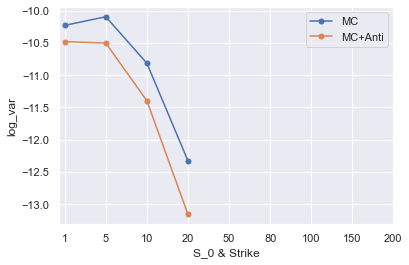

In [169]:
plot_for_param(series= std_list_anti, param= sk_list, labels= ["MC", "MC+Anti"]
               , x_name= "S_0 & Strike", y_name= "log_var")

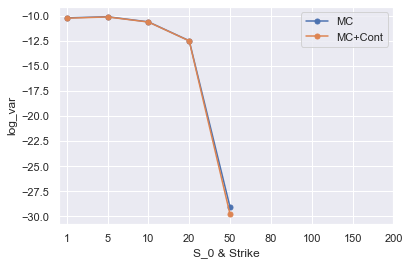

In [170]:
plot_for_param(series= std_list_cont, param= sk_list, labels= ["MC", "MC+Cont"]
               , x_name= "S_0 & Strike", y_name= "log_var")

##### Parameter S_0 in % of strike

In [171]:
# Params
T= 1
k= 20
s_0= 1
strike= 1
alpha= 0.2
b= 0
sigma= 0.3
r= 0.05
n= 100
num_exec= 1000

o_values_anti= []
o_values_cont= []
anti_values= []
cont_values= []

s_0_list= [0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4]
for s_0_i in s_0_list:
    print(s_0_i)
    start_time= time.time()
    # Simulation antithetic method
    original_value, antithetic_value= simulation_callvalue(num_exec, n, s_0_i, alpha, b, sigma, k, strike
                                                           , r, T, T/k)
    o_values_anti.append(original_value)
    anti_values.append(antithetic_value)
    
    # Simulation control method
    original_value2, control_value= simulation_control(num_exec, n, s_0_i, alpha, b, sigma, k, strike
                                                           , r, T, T/k)
    o_values_cont.append(original_value2)
    cont_values.append(control_value)
    
    print("Execution %s seconds" % (time.time()-start_time))

0.6
Execution 27.280376434326172 seconds


<ipython-input-130-cbe213df3032>:10: RuntimeWarning: divide by zero encountered in log
  a= np.log(serie)
<ipython-input-130-cbe213df3032>:10: RuntimeWarning: invalid value encountered in log
  a= np.log(serie)


Execution 27.097805976867676 seconds
Execution 54.37917971611023 seconds
0.7
Execution 26.855605840682983 seconds
Execution 26.95088768005371 seconds
Execution 53.806493520736694 seconds
0.8
Execution 26.827000856399536 seconds
Execution 27.063965320587158 seconds
Execution 53.890966176986694 seconds
0.9
Execution 27.031286478042603 seconds
Execution 27.102426528930664 seconds
Execution 54.13371300697327 seconds
1
Execution 27.761091947555542 seconds
Execution 28.051690578460693 seconds
Execution 55.812782526016235 seconds
1.1
Execution 26.89573621749878 seconds
Execution 26.994811058044434 seconds
Execution 53.891544818878174 seconds
1.2
Execution 27.231358528137207 seconds
Execution 27.362779140472412 seconds
Execution 54.59413766860962 seconds
1.3
Execution 26.955180644989014 seconds
Execution 27.397480726242065 seconds
Execution 54.35266137123108 seconds
1.4
Execution 26.8235764503479 seconds
Execution 27.01120162010193 seconds
Execution 53.83477807044983 seconds


In [172]:
# Normal MC
std_o_values_anti= list_of_val_to_list_std(o_values_anti)
std_o_values_cont= list_of_val_to_list_std(o_values_cont)
# COntrol and antithetic
std_anti_values= list_of_val_to_list_std(anti_values)
std_cont_values= list_of_val_to_list_std(cont_values)

std_list_anti= [np.log(std_o_values_anti), np.log(std_anti_values)]
std_list_cont= [np.log(std_o_values_cont), np.log(std_cont_values)]

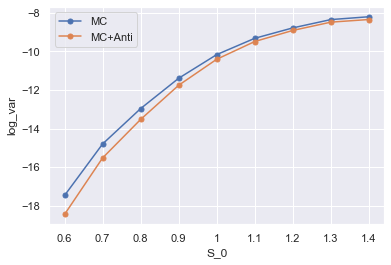

In [173]:
plot_for_param(series= std_list_anti, param= s_0_list, labels= ["MC", "MC+Anti"]
               , x_name= "S_0", y_name= "log_var")

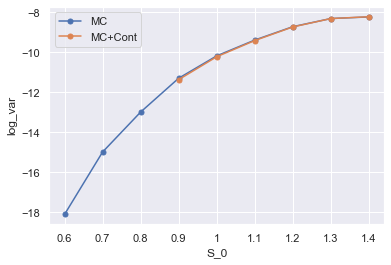

In [174]:
plot_for_param(series= std_list_cont, param= s_0_list, labels= ["MC", "MC+Cont"]
               , x_name= "S_0", y_name= "log_var")

### Multilevel Monte Carlo method

In [21]:
def compute_best_n_l(variance_serie, h_l_serie, l, rms_accuracy):
    assert variance_serie.shape == h_l_serie.shape
    summed_value= np.sum(np.sqrt(variance_serie/h_l_serie))
    rooted= np.sqrt(variance_serie[l]*h_l_serie[l])
    return int(summed_value * rooted * (2/(rms_accuracy**2)))

def mlmc_mean(serie, h_l):
    # the paper ignore sO
    return np.sum(0.5*(serie[1:] + serie[:-1])*h_l)
#     return np.mean(serie)

def compute_L_0_step(n_0, h_L, s_0, alpha, b, sigma, k, delta, strike):
    actualized_cashflow_0= []
    for i in range(n_0):
        s_l, _= cir_st_disc(s_0=s_0, alpha=alpha, b=b, sigma=sigma, k=k
                             , delta= h_L)
        # Compute mean and activation value
        execution_value= mlmc_mean(s_l, h_L)
        # Actualisation
        actualized_cashflow_0.append(actualization_execution_opt(execution_value - strike, r, T))
        
    return actualized_cashflow_0

def compute_l_step(n_l, l, s_0, alpha, b, sigma, k, strike, seed_key= 55):
    np.random.seed(seed_key)
    
    assert l > 0
    
    h_l= T/((M**l)*2)
    h_l1= T/((M**(l-1))*2)
    
    actualized_cashflow= []
    actualized_cashflow_1= []
    o= []
    for i in range(n_l):
        path_seed= int(np.random.uniform(0, pow(2, 32))) # we control each path to be the same
        # Only the timestemp change but the same path is simulated
        s_l, _= cir_st_disc(s_0=s_0, alpha=alpha, b=b, sigma=sigma, k=k
                             , delta= h_l, seed= path_seed)
        s_l1, _= cir_st_disc(s_0=s_0, alpha=alpha, b=b, sigma=sigma, k=k
                             , delta= h_l1, seed= path_seed)

        # Compute mean and activation value
        execution_value= mlmc_mean(s_l, h_l)
        execution_value_1= mlmc_mean(s_l1, h_l1)
        # Actualisation
        actualized_cashflow.append(actualization_execution_opt(execution_value - strike, r, T))
        actualized_cashflow_1.append(actualization_execution_opt(execution_value_1 - strike, r, T))
        
        o.append(s_l)

    return actualized_cashflow, actualized_cashflow_1, o

def convergence_test(Y_L, M, Y_L_1, rms_accuracy):
    left_side= np.abs(Y_L - (Y_L_1/M))
    right_side= (rms_accuracy*(M**2 - 1))/np.sqrt(2)
    return left_side < right_side

In [35]:
# Params
T= 1
k= 20
s_0= 1
strike= 1
alpha= 0.2
b= 0
sigma= 0.3
r= 0.05
n= 100
num_exec= 1000

L= 0 
n_0= 10**4
M= 2
h_L= T/((M**0)*2)

In [28]:
control_seed= int(np.random.uniform(0, pow(2, 32)))

In [36]:
def looking_for_best_nl(control_seed, n_0, s_0, alpha, b, sigma, k, strike
                        , rms_accuracy= 0.001):
    # first step L= 0
    start_time= time.time()

    L= 0 # INitialisation
    #n_0= 10**4 # From article
    M= 2 # From class
    h_L= T/((M**L)*2)
#     rms_accuracy= 0.001 # User definition

    np.random.seed(control_seed)

    v_L= []
    h_L_stock= []
    n_L_stock= []

    # Compute cash flos for L= 0
    actualized_cashflow_0= compute_L_0_step(n_0, h_L, s_0, alpha, b, sigma, k, h_L, strike)

    v_0= np.std(actualized_cashflow_0)**2

    v_L_copy= v_L.copy()
    v_L_copy.append(v_0)

    h_L_stock_copy= h_L_stock.copy()
    h_L_stock_copy.append(h_L)

    best_n_0= compute_best_n_l(np.array(v_L_copy), np.array(h_L_stock_copy)
                     , 0, rms_accuracy)

    # save best N_O for the moment
    n_L_stock.append(best_n_0)
    test_value= False
    while (L < 2) and (not test_value):
        print(L)
        L += 1
        # Compute values for l = 0
        # Compute cash flow for L= 0
        actualized_cashflow_0= compute_L_0_step(n_L_stock[0], h_L, s_0, alpha, b, sigma, k, h_L, strike)
        v_0= np.std(actualized_cashflow_0)**2

        # Initialize to this value (for the uncomputed n_l)
        n_L_stock.append(n_0)

        v_l_diff_stock= []
        v_l_diff_stock.append(v_0) # add to compute best n_l later

        for i in range(L): # compute values for l > 0 | l <= L
            l= i+1

            seed_key= int(np.random.uniform(0, pow(2, 32)))
            actualized_cashflow, actualized_cashflow_1, okok= compute_l_step(n_L_stock[l], l, s_0, alpha, b
                                                                       , sigma, k, strike= strike
                                                                       , seed_key= seed_key)

            diff_cash_flow= np.array(actualized_cashflow) - np.array(actualized_cashflow_1)
    #         diff_cash_flow_stock.append(diff_cash_flow)
            v_l_diff_stock.append(np.std(diff_cash_flow)**2)

        h_L_stock_copy= [h_L] + [T/((M**(j+1))*2) for j in range(L)]
        # compute best n_l l \in 0 ... L ==> (n_O, n_1 ... n_L)
        n_L_stock= [compute_best_n_l(np.array(v_l_diff_stock), np.array(h_L_stock_copy)
                , j, rms_accuracy) for j in range(L+1)]

        # We got best n_l for all l \in O, .. , L, now compute the good CF diff
        # Stock diff of CF
        actualized_cashflow_0= compute_L_0_step(n_L_stock[0], h_L, s_0, alpha, b, sigma, k, h_L, strike)
        diff_cash_flow_stock= []
        diff_cash_flow_stock.append(np.array(actualized_cashflow_0))
        for i in range(L): # compute values for l > 0 | l <= L
            l= i+1

            seed_key= int(np.random.uniform(0, pow(2, 32)))
            actualized_cashflow, actualized_cashflow_1, okok= compute_l_step(n_L_stock[l], l, s_0, alpha, b
                                                                       , sigma, k, strike= strike
                                                                       , seed_key= seed_key)

            diff_cash_flow= np.array(actualized_cashflow) - np.array(actualized_cashflow_1)
            diff_cash_flow_stock.append(diff_cash_flow)
            v_l_diff_stock.append(np.std(diff_cash_flow)**2)

        # Convergence test if L >= 2, can stop the process
        if L >= 2:
            y_l= np.sum(diff_cash_flow_stock[-1]/n_L_stock[-1])
            y_l1= np.sum(diff_cash_flow_stock[-2]/n_L_stock[-2])
            test_value= convergence_test(y_l, M, y_l1, rms_accuracy)

    print("Execution %s seconds" % (time.time()-start_time))
    
    return n_L_stock, diff_cash_flow_stock

In [37]:
n_L_stock, diff_cash_flow_stock= looking_for_best_nl(control_seed, n_0, s_0, alpha, b, sigma, k, strike
                                                    , rms_accuracy= 0.001)

0
1
Execution 22.82171893119812 seconds


In [38]:
def call_value_mlmc(diff_cash_flow_stock, n_L_stock):
    diff_value= np.array([np.sum(d) for d in diff_cash_flow_stock])/np.array(n_L_stock)
    return np.sum(diff_value)

In [39]:
# test the function, seems to be ok since the value is around the mean of MC call simulation
call_value_mlmc(diff_cash_flow_stock, n_L_stock)

0.026467345588951873

In [42]:
# Simulate with the best param over num_exec sim
def compute_call_value_mlmc(control_seed, n_L_stock, s_0, alpha, b, sigma, k, h_L, strike):
    np.random.seed(control_seed)
    
#     start_time= time.time()

    L= len(n_L_stock) # true L is that value minus 1, because l \in 0, .. , L
    h_l= [T/((M**(j))*2) for j in range(L)]

    v_l_diff_stock= []
    #Stock diff of CF
    actualized_cashflow_0= compute_L_0_step(n_L_stock[0], h_l[0], s_0, alpha, b, sigma, k, h_L, strike)
    diff_cash_flow_stock= []
    diff_cash_flow_stock.append(np.array(actualized_cashflow_0))
    actualized_cashflow_stock= []
    actualized_cashflow_stock.append(actualized_cashflow_0)
    for i in range(L-1): 
        l= i+1
        seed_key= int(np.random.uniform(0, pow(2, 32)))
        actualized_cashflow, actualized_cashflow_1, okok= compute_l_step(n_L_stock[l], l, s_0, alpha, b
                                                                   , sigma, k, strike= strike
                                                                   , seed_key= seed_key)
        actualized_cashflow_stock.append(actualized_cashflow)
        diff_cash_flow= np.array(actualized_cashflow) - np.array(actualized_cashflow_1)
        diff_cash_flow_stock.append(diff_cash_flow)
        v_l_diff_stock.append(np.std(diff_cash_flow)**2)

    call_val= call_value_mlmc(diff_cash_flow_stock, n_L_stock)
#     print("Execution %s seconds" % (time.time()-start_time))
    
    return call_val, v_l_diff_stock, diff_cash_flow_stock, actualized_cashflow_stock

In [43]:
call_val, v_l_diff_stock, diff_cash_flow_stock, actualized_cashflow_stock= compute_call_value_mlmc(control_seed, n_L_stock, s_0
                                                                            , alpha, b, sigma, k, h_L, strike)

In [44]:
print(call_val)

0.027251974126972823


In [45]:
# Like the article, compare diff cash flow variance with cashflow variance
article_var_esti_diff= np.array([np.std(d)**2 for d in diff_cash_flow_stock[1:]])#/np.array(n_L_stock)
var_log_diff= np.log(article_var_esti_diff)
print(var_log_diff)

[-6.63324236 -6.52510108]


In [46]:
var_log_vanilla= np.log(np.array([np.std(d)**2 for d in actualized_cashflow_stock]))

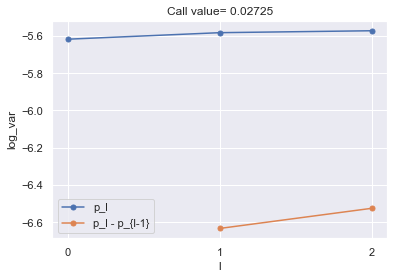

In [47]:
# Add NaN for the first var_log_diff element
var_log_diff_full= np.insert(var_log_diff, 0, np.nan, axis=0)

plot_for_param(series= [var_log_vanilla, var_log_diff_full], param= [0, 1, 2]
               , labels= ["p_l", "p_l - p_{l-1}"], x_name= "l", y_name= "log_var"
              , title= "Call value= {}".format(round(call_val, 5)))

It looks like the paper baby !!

### Quasi Monte Carlo

In [51]:
def cir_st_lowdiscr(s_0, alpha, b, sigma, p, k: int= 20, delta: float=1):

    # Instance stock price ts and append it first value
    s_t = []
    s_t.append(s_0)
    sob = sobol_seq.i4_sobol_generate(k, p)
    for i in range(k):
        s_t_value= np.maximum(s_t[-1], 0) 
        mu= alpha*(b - s_t_value)
        sigma_s_t= sigma * np.sqrt(s_t_value * delta) 
        d_s_t= delta*mu + sigma_s_t*norm.ppf(sob[p-1][i])
        s_t.append(s_t_value + d_s_t)
    return np.array(s_t)

In [59]:
def lowdiscr_path(s_0, alpha, b, sigma,n, k: int= 20, delta: float=1):
    path = []
    for p in range(1,n+1):
        path.append(cir_st_lowdiscr(s_0, alpha, b, sigma, p, k, delta))
    return path

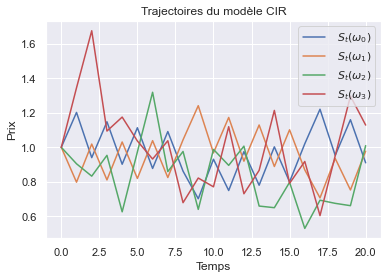

In [103]:
paths3 = lowdiscr_path(s_0, alpha, 1, sigma, n) # b= 1 (Long run value)

for i in range(4):
    plt.plot(paths3[i+1],label = ' $S_{t}(\omega_{%s})$' % i)

plt.title('Trajectoires du modèle CIR')
plt.xlabel('Temps')
plt.ylabel('Prix')
plt.legend()
plt.show()

In [107]:
# Simulation step
all_path= lowdiscr_path(s_0, alpha, 1, sigma, 100)[1:]

In [111]:
cashflow_qmc= [execution_opt_diff(s_t= path, strike= strike) for path in all_path]

actu_cash_flow_qmc= [actualization_execution_opt(cf, r, T) for cf in cashflow_qmc]

In [113]:
np.mean(actu_cash_flow_qmc)

0.07732289887593943